# Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
from keras.utils import to_categorical
import keras.losses
from keras.optimizers import SGD
import pickle
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

Using TensorFlow backend.


# Functions

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [3]:
def feature_selection(images,variance_lower_limit):
    selector = VarianceThreshold(variance_lower_limit)
    images_reduced = selector.fit_transform(images)
    print("Images original shape: ",images.shape)
    print("Images reduced shape: ",images_reduced.shape)
    return images_reduced

In [4]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img):
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [5]:
# set values from cropping images
offset_height=40
offset_width=30
target_height=30
target_width=50

#flatten dataset of image names to dataset with flattened image pixels
def create_flattened_dataset(dataset,size,crop_bool):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        #cropped image size = (30,50,3)
        if crop_bool == True:
            x=img_to_array(img)
            x_cropped = tf.image.crop_to_bounding_box(x, offset_height, offset_width, target_height, target_width)
            x_cropped =tf.keras.preprocessing.image.array_to_img(x_cropped, data_format=None, scale=True, dtype=None)
            img_vector=load_reshape_img(x_cropped)
        else:
            img_vector=load_reshape_img(img)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
    dataset_np=np.stack(dataset_copy)
    dataset_pd = pd.DataFrame(dataset_np)
    return(dataset_pd)

In [6]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")
    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")    
    return

In [7]:
def Print_Classification_Results(y_dev,y_pred):
    print(classification_report(y_dev, y_pred))
    acc_score = accuracy_score(y_dev, y_pred)
    print("\nAccuracy Score: ","{:.3%}".format(acc_score))
    conf_matrix = confusion_matrix(y_dev, y_pred)
    labels=['0','1','2','3','4']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return acc_score

In [8]:
def evaluate_and_plot(model, history, X_train, y_train, X_dev, y_dev, y_pred):  
    # evaluate the model
    y_train_c = to_categorical(y_train)
    y_dev_c = to_categorical(y_dev)
    
    train_loss, train_acc = model.evaluate(X_train, y_train_c, verbose=0)
    dev_loss, dev_acc = model.evaluate(X_dev, y_dev_c, verbose=0)
    print('Train: %.3f, Dev: %.3f' % (train_acc, dev_acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # plot loss during training
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='dev')
    ax1.legend()
    ax1.set_ylim([-0.1,1])

    # plot accuracy during training
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='dev')
    ax2.legend()
    ax2.set_ylim([0,1.2])
    plt.show()

    accuracy = Print_Classification_Results(y_dev,y_pred)
    return(accuracy)

In [9]:
def plot_images_true_predicted_eyeColor(labels,predictions,images_folder):
    fig = plt.gcf()
    fig.set_size_inches(16,20)
    for i in range(21):
        ax = plt.subplot(5,7,1+i)
        img_id = labels.index.values[i].astype(int)
        img_id = images_folder + str(img_id)+'.png'
        img = load_img(img_id)
        ax.imshow(img, cmap='binary')
        title ="Label=" + str(labels.iloc[i]) + ",Prediction= " +str(predictions[i]) 
        ax.set_title(title,fontsize=10)
    plt.show()
    return

# Read Data

In [13]:
images_folder = '../Datasets/cartoon_set/img/'
dataset = pd.read_csv('../Datasets/cartoon_set/labels.csv', sep = '\t', usecols = [1,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (10000, 2)


,eye_color,file_name
0,1,0.png
1,2,1.png
2,2,2.png
3,2,3.png
4,0,4.png


In [14]:
images = dataset.iloc[:,1]
labels = dataset.iloc[:,0]

Example of cartoons in Cartoon dataset:

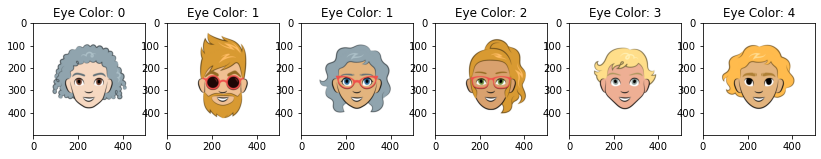

In [15]:
images_folder = '../Datasets/cartoon_set/img/'
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(14, 3))

EXAMPLE_PIC = images_folder + '4.png'
ax1.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax1.imshow(img)

EXAMPLE_PIC = images_folder + '0.png'
ax2.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax2.imshow(img)

EXAMPLE_PIC = images_folder + '8.png'
ax3.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax3.imshow(img)

EXAMPLE_PIC = images_folder + '2.png'
ax4.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax4.imshow(img)

EXAMPLE_PIC = images_folder + '6.png'
ax5.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax5.imshow(img)

EXAMPLE_PIC = images_folder + '19.png'
ax6.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax6.imshow(img)

## Elaborate on multiclass labels

Class=1, n=2018 (20.180%)
Class=2, n=1969 (19.690%)
Class=0, n=2004 (20.040%)
Class=4, n=2017 (20.170%)
Class=3, n=1992 (19.920%)


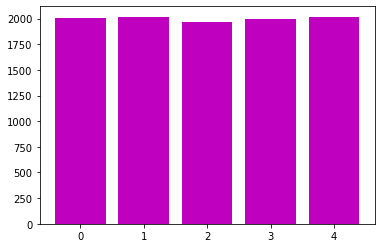

In [16]:
# summarize distribution
counter = Counter(labels)
for k,v in counter.items():
    per = v / len(labels) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values(),color='m')
plt.show()

**Balanced Dataset!!**

## Convert cartoon images dataframe to reshaped flattened array images dataframe

* First, as long as we are interested in cartoon's eye color, which don't need high resolution (since they are cartoons, not human faces), we reduce image shape from (IMG_HEIGHT,IMG_WIDTH)=(500,500) to 110 each, but DO NOT transform images to gray scale, we need color!!!!


* We apply this transformaton from the beginning since we have quite a big dataset with high dimensional features that our computational resources cannot handle in their raw format.

Example of how images will be converted:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)


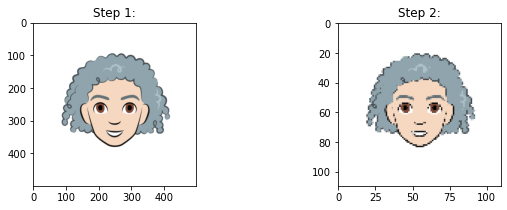

In [17]:
EXAMPLE_PIC = images_folder + '4.png'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (110,110,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

plt.show()

In [18]:
size=(110,110)
crop_bool = False
reshaped_images=create_flattened_dataset(images,size,crop_bool)
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


## Remove features with zero information (white pixels of background)

### Feature Selection:
If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed. 
In this problem, these constant fetures are the white pixels of background.

In [48]:
variance_lower_limit=0
reshaped_images_reduced=feature_selection(reshaped_images,variance_lower_limit)

Images original shape:  (10000, 36300)
Images reduced shape:  (10000, 20175)


## Split reshaped dataset into train, dev, test sets

In [49]:
X_train_, X_test_, X_dev_, y_train_, y_test_, y_dev_=train_dev_test_split(reshaped_images_reduced, labels)

Train Set: (7000, 20175) | Dev Set: (1500, 20175) | Test Set: (1500, 20175)


# Baseline Multiclass Classifiers

## 1. Linear SVM

Linear SVM implements “one-vs-one” multi-class strategy, thus training n_classes(=5) models.

Total runtime:  725.1424336433411 s
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       308
           1       0.78      0.81      0.80       312
           2       0.79      0.75      0.77       315
           3       0.81      0.78      0.80       275
           4       0.88      0.81      0.85       290

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.80      0.80      0.80      1500


Accuracy Score:  80.200%


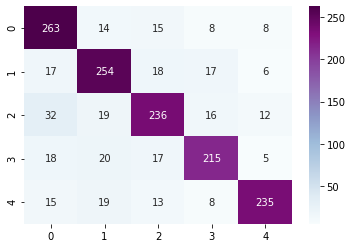

In [45]:
kernel='linear'
gamma='scale'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train_, y_train_)
y_pred = clf_svm_linear.predict(X_dev_)
runtime_linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_linear_SVM,"s")
acc_linear_SVM = Print_Classification_Results(y_dev_,y_pred)

## 2. Logistic Regression

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Total runtime:  24.28664803504944 s
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       308
           1       0.86      0.81      0.83       312
           2       0.79      0.78      0.78       315
           3       0.82      0.81      0.82       275
           4       0.77      0.83      0.80       290

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500


Accuracy Score:  80.800%


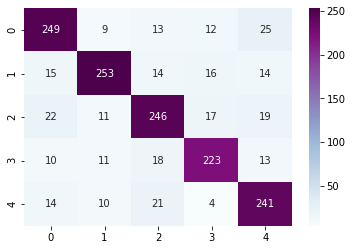

In [26]:
clf_lr_base = LogisticRegression()
start_time = time.time()
clf_lr_base.fit(X_train_, y_train_)
y_pred = clf_lr_base.predict(X_dev_)
runtime_lr_base = time.time()-start_time
print("Total runtime: ",runtime_lr_base,"s")
acc_lr_base = Print_Classification_Results(y_dev_,y_pred)

# Preproccessing Data

## 1. Crop Images

Since each and every cartoon image in our custom dataset is centered, we crop all images holding only the frame (set height, width offsets manually) that covers the eyes with some extra padding to guarantee that always the eyes will be concluded.

### Example of cropped images:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)
Step 3 image size: (30, 50, 3)


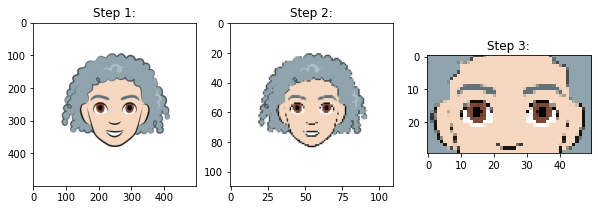

In [19]:
EXAMPLE_PIC = images_folder + '4.png'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (110,110,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

#cropped image size = (30,50,3)
x=img_to_array(img)
offset_height=40
offset_width=30
target_height=30
target_width=50
x_cropped = tf.image.crop_to_bounding_box(
    x, offset_height, offset_width, target_height, target_width
)
x_cropped =tf.keras.preprocessing.image.array_to_img(
    x_cropped, data_format=None, scale=True, dtype=None)
ax3.imshow(x_cropped)
ax3.set_title("Step 3:")
print("Step 3 image size:",img_to_array(x_cropped).shape)

plt.show()

### Create new flattened dataset

In [20]:
size=(110,110)
crop_bool = True
reshaped_images_cropped=create_flattened_dataset(images,size,crop_bool)
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images_cropped, labels)

Train Set: (7000, 4500) | Dev Set: (1500, 4500) | Test Set: (1500, 4500)


# Baseline Multiclass Classifiers for Cropped Images

## 1. Linear SVM

* Perform GridSearch to find best fitted estimator.
* Fit Train Data on estimators and predict on Dev Data

**We dont use the original function of GridSearch since cross validation that it supports, requires too much computational resources that we dont have, so we always train our models on Train set and validate them on Dev Set.**

In [20]:
# defining parameter range 
C = [1, 10, 100]
gamma= ['scale','auto']
kernel = 'linear'

scores=[]
best_score = 0

for g in gamma:
    for c_ in C:
        clf_svc = SVC(gamma = g, C = c_, kernel = kernel)
        clf_svc.fit(X_train, y_train)
        # evaluate the LR on the dev set
        score = clf_svc.score(X_dev, y_dev)
        scores.append(score)
        parameters={'Gamma':g, 'C':c_}
        print("Score: {:.5f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'Gamma':g, 'C':c_}

Score: 0.81867 for Parameters: {'Gamma': 'scale', 'C': 1}
Score: 0.81867 for Parameters: {'Gamma': 'scale', 'C': 10}
Score: 0.82000 for Parameters: {'Gamma': 'scale', 'C': 100}
Score: 0.81867 for Parameters: {'Gamma': 'auto', 'C': 1}
Score: 0.81867 for Parameters: {'Gamma': 'auto', 'C': 10}
Score: 0.82000 for Parameters: {'Gamma': 'auto', 'C': 100}


Total runtime:  284.358820438385 s
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       308
           1       0.82      0.84      0.83       312
           2       0.82      0.80      0.81       315
           3       0.81      0.83      0.82       275
           4       0.85      0.82      0.84       290

    accuracy                           0.82      1500
   macro avg       0.83      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500


Accuracy Score:  82.467%


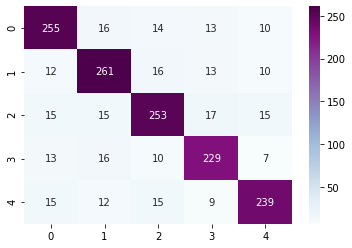

In [20]:
clf_svc_linear = SVC(gamma = best_parameters['Gamma'], C = best_parameters['C'], kernel =  kernel)
start_time = time.time()
# Train the model using the training sets
clf_svc_linear.fit(X_train, y_train)
preds_svc_linear= clf_svc_linear.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_linear_SVM_cropped = Print_Classification_Results(y_dev,preds_svc_linear)

## 2. SVC with RBF kernel

Score: 0.80 for Parameters: {'Gamma': 0.01, 'C': 1}
Score: 0.80 for Parameters: {'Gamma': 0.01, 'C': 10}
Score: 0.80 for Parameters: {'Gamma': 0.01, 'C': 100}
Score: 0.82 for Parameters: {'Gamma': 0.001, 'C': 1}
Score: 0.83 for Parameters: {'Gamma': 0.001, 'C': 10}
Score: 0.82 for Parameters: {'Gamma': 0.001, 'C': 100}
Score: 0.74 for Parameters: {'Gamma': 0.0001, 'C': 1}
Score: 0.82 for Parameters: {'Gamma': 0.0001, 'C': 10}
Score: 0.83 for Parameters: {'Gamma': 0.0001, 'C': 100}

Best score: 0.83
Best parameters: {'Gamma': 0.0001, 'C': 100}
Total runtime:  164.15012526512146 s
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       308
           1       0.86      0.84      0.85       312
           2       0.85      0.79      0.82       315
           3       0.81      0.83      0.82       275
           4       0.80      0.86      0.83       290

    accuracy                           0.83      1500
   macro avg       0.83      0.83 

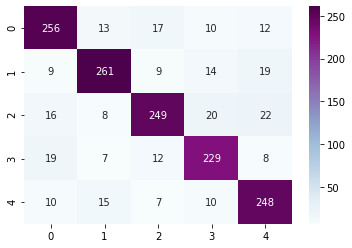

In [17]:
# defining parameter range 
C = [1, 10, 100]
gamma= [1e-2, 1e-3, 1e-4]
kernel = 'rbf'

scores=[]
best_score_rbf = 0

for g in gamma:
    for c_ in C:
        clf_svc = SVC(gamma = g, C = c_, kernel = kernel)
        clf_svc.fit(X_train, y_train)
        # evaluate the LR on the dev set
        score = clf_svc.score(X_dev, y_dev)
        scores.append(score)
        parameters={'Gamma':g, 'C':c_}
        print("Score: {:.2f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score_rbf = score
            best_parameters_rbf = {'Gamma':g, 'C':c_}
print("\nBest score: {:.5f}".format(best_score_rbf))
print("Best parameters: {}".format(best_parameters_rbf))

#for optimal parameters take classification report
clf_svc_rbf = SVC(gamma = best_parameters_rbf['Gamma'], C = best_parameters_rbf['C'], kernel =  kernel)
start_time = time.time()
# Train the model using the training sets
clf_svc_rbf.fit(X_train, y_train)
preds_svc_rbf= clf_svc_rbf.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_SVM_rbf_cropped = Print_Classification_Results(y_dev,preds_svc_rbf)

## 3. Logistic Regression

In [23]:
C = [0.01,0.1,1,10,50]
penalty = ['l1','l2']
solver = 'liblinear'

scores=[]
best_score = 0
for p in penalty:
    for c_ in C:
        clf_lr = LogisticRegression( C = c_, solver = solver, penalty = p)
        clf_lr.fit(X_train, y_train)
        # evaluate the LR on the dev set
        score = clf_lr.score(X_dev, y_dev)
        scores.append(score)
        parameters={'Penalty': p, 'C':c_}
        print("Score: {:.5f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'Penalty': p, 'C':c_}
print("\nBest score: {:.5f}".format(best_score))
print("Best parameters: {}".format(best_parameters))
acc_lr = best_score

Score: 0.81933 for Parameters: {'Penalty': 'l1', 'C': 0.01}
Score: 0.82133 for Parameters: {'Penalty': 'l1', 'C': 0.1}
Score: 0.84200 for Parameters: {'Penalty': 'l1', 'C': 1}
Score: 0.83867 for Parameters: {'Penalty': 'l1', 'C': 10}
Score: 0.83333 for Parameters: {'Penalty': 'l1', 'C': 50}
Score: 0.81933 for Parameters: {'Penalty': 'l2', 'C': 0.01}
Score: 0.83867 for Parameters: {'Penalty': 'l2', 'C': 0.1}
Score: 0.83733 for Parameters: {'Penalty': 'l2', 'C': 1}
Score: 0.83467 for Parameters: {'Penalty': 'l2', 'C': 10}
Score: 0.83533 for Parameters: {'Penalty': 'l2', 'C': 50}

Best score: 0.84200
Best parameters: {'Penalty': 'l1', 'C': 1}


## Final Baseline Classifier

In [2]:
data={'Linear SVM':[acc_linear_SVM],'Linear SVC(Gamma: scale, C: 100) - cropped':[acc_linear_SVM_cropped],
      'RBF SVC(Gamma: 0.0001,C: 100) - cropped':[acc_SVM_rbf_cropped],
      'Logistic Regression {} - cropped'.format(best_parameters):[acc_lr]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)

,Accuracy Score
"Logistic Regression {'Penalty': 'l1', 'C': 1} - cropped",0.842000
"RBF SVC(Gamma: 0.0001,C: 100) - cropped",0.828667
"Linear SVC(Gamma: scale, C: 100) - cropped",0.824667
Linear SVM,0.802000


Hence the classifier **{Logistic Regression with Penalty='l1', C=1.0, solver='liblinear'}** is the best baseline classifier till now.

# Preprocessing Data - Curse of Dimensionality

Since our cropped dataset doesn't have obvious features-pixels with zero variance, hence we have no evident redundant features, we perform directly Feature Extraction (PCA) rather than Feature Selection(Variance Threshold)

## Feature Extraction - PCA

(7000, 4500)
(7000, 300)
[0.9955434  0.99550664 0.9954693  0.99543166 0.9953935  0.9953551
 0.9953156  0.995276   0.9952362 ]


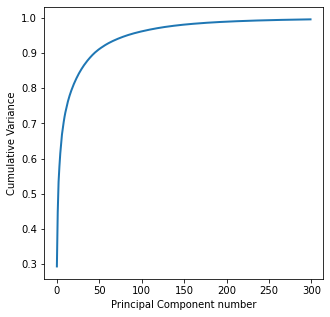

In [30]:
n = 300
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)
X_test_PCA = pca.transform(X_test)
print(X_train.shape)
print(X_train_PCA.shape)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar[:-10:-1])
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

From this plot we can infer what amount of variance is represented by the corresponding number of PCA components.
Almost 90% of the information given from features is explained by 50 PCA components.

In [19]:
best_score = 0
scores_train=[]
scores_dev=[]
n_components = [100,150,200,250,300,500,700,1000]
for n in n_components:
    pca = PCA(n_components=n)
    X_train_PCA = pca.fit_transform(X_train)
    X_dev_PCA = pca.transform(X_dev)
    clf = LogisticRegression(solver = 'liblinear', penalty ='l1', C = 1.0)
    clf.fit(X_train_PCA, y_train)
    # evaluate the SVC on the dev set
    score_train=clf.score(X_train_PCA, y_train)
    score_dev=clf.score(X_dev_PCA, y_dev)
    parameter={'n_components PCA':n}
    print("Score: {:.5f}".format(score_dev), "for Parameter: {}".format(parameter))
    # if we got a better score, store the score and parameters
    scores_train.append(score_train)
    scores_dev.append(score_dev)
    if score_dev > best_score:
        best_score = score_dev
        best_parameter = {'n_components PCA':n}

print("\nBest score: {:.3%}".format(best_score))
print("Best parameter: {}".format(best_parameter))

Score: 0.80600 for Parameter: {'n_components PCA': 100}
Score: 0.82600 for Parameter: {'n_components PCA': 150}
Score: 0.83533 for Parameter: {'n_components PCA': 200}
Score: 0.84067 for Parameter: {'n_components PCA': 250}
Score: 0.84333 for Parameter: {'n_components PCA': 300}
Score: 0.83933 for Parameter: {'n_components PCA': 500}
Score: 0.83800 for Parameter: {'n_components PCA': 700}
Score: 0.83867 for Parameter: {'n_components PCA': 1000}

Best score: 84.333%
Best parameter: {'n_components PCA': 300}


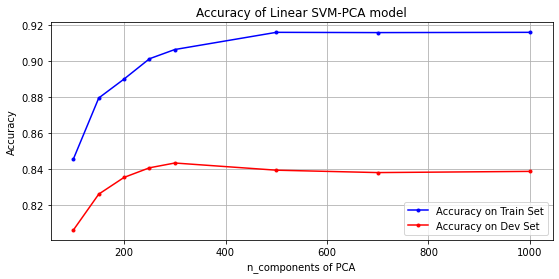

In [20]:
plt.figure(figsize=(9,4))
plt.title('Accuracy of Linear SVM-PCA model')

plt.plot(n_components,scores_train,'r.-', c ='b',label='Accuracy on Train Set')
plt.plot(n_components,scores_dev, 'r.-', c='r',label='Accuracy on Dev Set')
plt.ylabel('Accuracy')
plt.xlabel('n_components of PCA')
plt.grid()
plt.legend()
plt.show()

### Logistic Regression (Penalty='l1', C=1.0, solver='liblinear')

Total runtime:  12.984297752380371 s
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       308
           1       0.85      0.84      0.84       312
           2       0.88      0.82      0.85       315
           3       0.84      0.85      0.85       275
           4       0.82      0.86      0.84       290

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.400%


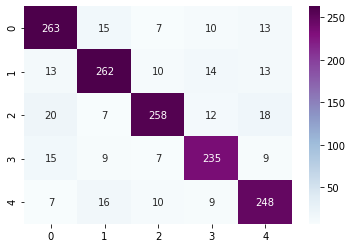

In [87]:
n = 300
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)
X_test_PCA = pca.transform(X_test)

clf_lr_PCA = LogisticRegression(solver = 'liblinear', penalty ='l1', C = 1.0)
start_time = time.time()
clf_lr_PCA.fit(X_train_PCA, y_train)
preds_lr_PCA= clf_lr_PCA.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
acc_lr_PCA = Print_Classification_Results(y_dev,preds_lr_PCA)

# Compare all previous models

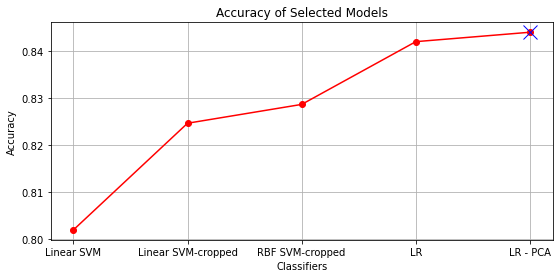

Best Clasifier till now: Logistic Regression with Parameters {'Penalty': 'l1', 'C': 1} 
and PCA preprocessing with n_components = 300 
and accuracy = 84.40%


In [7]:
accuracies = [acc_linear_SVM, acc_linear_SVM_cropped, acc_SVM_rbf_cropped, acc_lr, acc_lr_PCA]
accuracies = np.array(accuracies)
acc_list=['Linear SVM','Linear SVM-cropped','RBF SVM-cropped',
           'LR', 'LR - PCA']

plt.figure(figsize=(9, 4))
plt.title('Accuracy of Selected Models')
plt.plot(acc_list,accuracies, 'r.-',marker = 'o')

#spot maximum accuracy
acc_max = np.array(accuracies).max()
index=np.where(accuracies==acc_max)
index = index[0][0]
plt.plot(acc_list[index],acc_max,'x',color='b',markersize=14)

plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
#plt.xticks(rotation=10)
plt.grid()
plt.show()

print('Best Clasifier till now: Logistic Regression with Parameters {}'.format(best_parameters),
      '\nand PCA preprocessing with n_components = 300', '\nand accuracy = {:.2%}'.format(acc_max))

# Best performing model

As we said previously, best model for our task is a Logistic Regression with Parameters {'Penalty': 'l1', 'C': 1} 
and PCA preprocessing with n_components = 300.

Load model...
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       308
           1       0.84      0.85      0.84       312
           2       0.87      0.82      0.85       315
           3       0.85      0.85      0.85       275
           4       0.82      0.85      0.84       290

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.267%


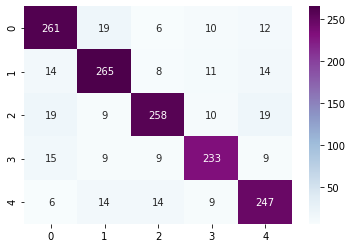

In [56]:
n = 300
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)
X_test_PCA = pca.transform(X_test)

clf_lr_PCA = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 1.0 )
start_time = time.time()
# Train the model using the training sets
clf_lr_PCA.fit(X_train_PCA, y_train)
preds= clf_lr_PCA.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
accuracy = Print_Classification_Results(y_dev,preds)

# Save to file in the current working directory
pkl_filename = "model_B2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_lr_PCA, file)

## Evaluate on Dev Set:

Load model...
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       308
           1       0.84      0.85      0.84       312
           2       0.87      0.82      0.85       315
           3       0.85      0.85      0.85       275
           4       0.82      0.85      0.84       290

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.267%


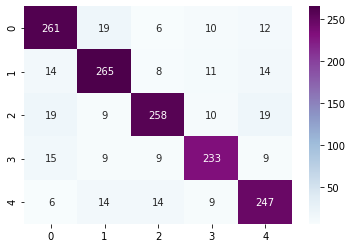

In [56]:
# Load from file
pkl_filename = "model_B2.pkl"
print('Load model...')
with open(pkl_filename, 'rb') as file:
    model_B2 = pickle.load(file)

preds = model_B2.predict(X_dev_PCA)
accuracy_test = Print_Classification_Results(y_dev,preds)

## Evaluate on Test Set:

Load model...
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       312
           1       0.83      0.85      0.84       281
           2       0.81      0.85      0.83       299
           3       0.87      0.86      0.87       296
           4       0.82      0.84      0.83       312

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500


Accuracy Score:  84.533%


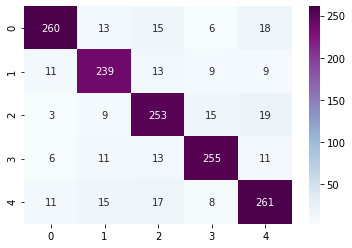

In [46]:
# Load from file
pkl_filename = "model_B2.pkl"
print('Load model...')
with open(pkl_filename, 'rb') as file:
    model_B2 = pickle.load(file)

preds = model_B2.predict(X_test_PCA)
accuracy_test = Print_Classification_Results(y_test,preds)

Our model is almost perfect if we take into consideration that a great amount of cartoons wear sun glasses which makes  the recognition of their eye color impossible. Hence their allocation to any of 5 classes becomes based on some other patterns of their features that models has been trained to recognised, which features actually can't contribute to the eye color classification since all cartoons irrespective of eye color, share characteristics from a specific range (in simple words eye color is an independent variable to the other features, see below for justification).

## Compare Baseline and Best model's Accurracy

### Baseline model vs Best model

* *Estimator*: Logistic Regression with Default Parameters {'kernel': 'lbfgs','Penalty': 'l2', 'C': 1} **vs** Logistic Regression with Parameters {'kernel': 'liblinear','Penalty': 'l1', 'C': 1}
* *Training Data*: Flattened images of size=(110,110) in RGB scale **vs** Cropped Flattened images of size=(30,50) in RGB scale before being fed to PCA preprocessing with n_components = 300, which means that our model reaches better accuracy **with much less amount of features**.


Accuracy Score of Test Set for Baseline Model:  81.400%

Accuracy Score of Test Set for Best Model:  84.533%


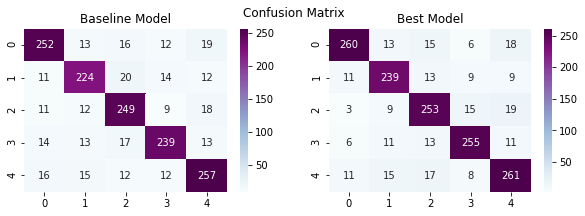

In [51]:
#Baseline model
preds_lr_base= clf_lr_base.predict(X_test_)
acc_lr_base = accuracy_score(y_test_, preds_lr_base)
print("\nAccuracy Score of Test Set for Baseline Model: ","{:.3%}".format(acc_lr_base))
conf_matrix1 = confusion_matrix(y_test_, preds_lr_base)

#Best model
preds= model_B2.predict(X_test_PCA)
accuracy = accuracy_score(y_test,preds)
print("\nAccuracy Score of Test Set for Best Model: ","{:.3%}".format(accuracy))
conf_matrix2 = confusion_matrix(y_test, preds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Confusion Matrix', fontsize=12)
labels=['0','1','2','3','4']

ax1.set_title('Baseline Model')
sns.heatmap(conf_matrix1, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax1)

ax2.set_title('Best Model')
sns.heatmap(conf_matrix2, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax2)
plt.show()

### Plot Baseline Logistic Regression and Best model accuracy on Train, Dev and Test Data

In [54]:
preds = clf_lr_base.predict(X_train_)
acc_lr_base_train = accuracy_score(y_train_, preds)
preds = clf_lr_base.predict(X_dev_)
acc_lr_base_dev = accuracy_score(y_dev_, preds)
preds = clf_lr_base.predict(X_test_)
acc_lr_base_test = accuracy_score(y_test_, preds)

preds = model_B2.predict(X_train_PCA)
acc_lr_train= accuracy_score(y_train,preds)
preds = model_B2.predict(X_dev_PCA)
acc_lr_dev= accuracy_score(y_dev,preds)
preds = model_B2.predict(X_test_PCA)
acc_lr_test= accuracy_score(y_test,preds)

|                 |   Train Accuracy |   Dev Accuracy |   Test Accuracy |
|:----------------|-----------------:|---------------:|----------------:|
| Baseline LogReg |         0.857429 |       0.808    |        0.814    |
| Best LogReg     |         0.900429 |       0.842667 |        0.845333 |


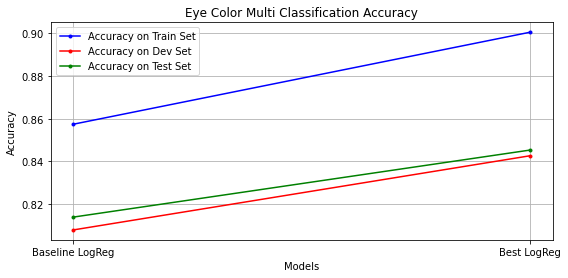

In [53]:
models=["Baseline LogReg","Best LogReg"]
scores_train = [acc_lr_base_train, acc_lr_train]
scores_dev = [acc_lr_base_dev, acc_lr_dev]
scores_test = [acc_lr_base_test, acc_lr_test]
data={'Baseline LogReg':[acc_lr_base_train,acc_lr_base_dev,acc_lr_base_test],
      'Best LogReg':[acc_lr_train,acc_lr_dev,acc_lr_test]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Train Accuracy','Dev Accuracy','Test Accuracy'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)
print(df.to_markdown()) 



plt.figure(figsize=(9,4))
plt.title('Eye Color Multi Classification Accuracy')

models=["Baseline LogReg","Best LogReg"]
scores_train = [acc_lr_base_train, acc_lr_train]
scores_dev = [acc_lr_base_dev, acc_lr_dev]
scores_test = [acc_lr_base_test, acc_lr_test]

plt.plot(models,scores_train,'r.-', c ='b',label='Accuracy on Train Set')
plt.plot(models,scores_dev, 'r.-', c='r',label='Accuracy on Dev Set')
plt.plot(models,scores_test, 'r.-', c='g',label='Accuracy on Test Set')

plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.grid()
plt.legend()
plt.show()

**Since our model enhanced the accuracy of prediction on Test Data too, means that we neither overfit our model on Train Data, nor fined-tune it on Validation (Dev) Data.**

**Also, we can observe just by examining the given dataset, a substantial portion of samples constists of cartoon with sunglasses, which means their eye color is not visible, hence these samples add a misdirection/bias in our model that can't be averted, only if a computer vision preprocessing is being applied. Supposing that these samples could be a 20% of total dataset, the final accuracy that we get is totally explainable and it could be deemed almost perfect since there is no chance and no algorithm that could classify correctly cartoons with sunglasses.**

## Model Performance on Test Data

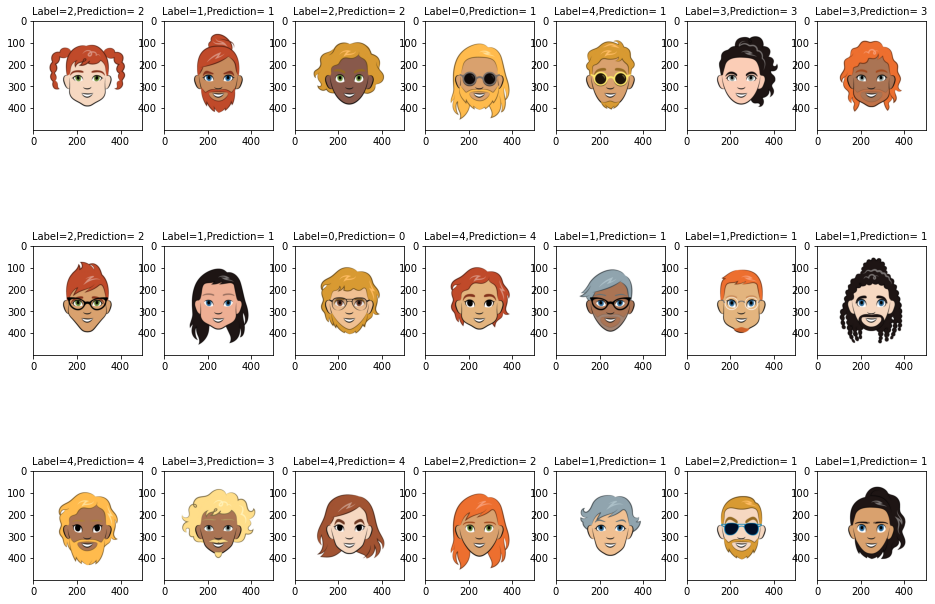

In [22]:
plot_images_true_predicted_eyeColor(y_test,preds,images_folder)

## Evaluate the previous model on new test data

Dataset Test Size:  (2500, 2)
Load model...
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       506
           1       0.81      0.84      0.83       483
           2       0.86      0.86      0.86       525
           3       0.87      0.83      0.85       514
           4       0.83      0.88      0.85       472

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500


Accuracy Score:  84.640%


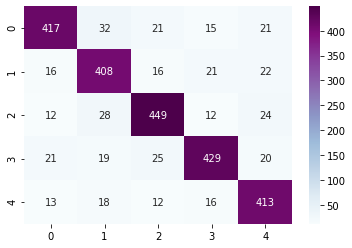

In [21]:
images_folder = '../Datasets/dataset_AMLS_20-21_test/cartoon_set_test/img/'
dataset_test = pd.read_csv('../Datasets/dataset_AMLS_20-21_test/cartoon_set_test/labels.csv', sep = '\t', usecols = [1,3])
print("Dataset Test Size: ",dataset_test.shape)
images_test = dataset_test.iloc[:,1]
labels_test = dataset_test.iloc[:,0]

size=(110,110)
crop_bool = True
X_test=create_flattened_dataset(images_test,size,crop_bool)
y_test=labels_test

X_test_PCA = pca.transform(X_test)

# Load from file
pkl_filename = "model_B2.pkl"
print('Load model...')
with open(pkl_filename, 'rb') as file:
    model_B2 = pickle.load(file)

preds = model_B2.predict(X_test_PCA)
accuracy_test = Print_Classification_Results(y_test,preds)

## Train from scratch the best performing model

In [ ]:
images_folder = '../Datasets/cartoon_set/img/'

dataset = pd.read_csv('../Datasets/cartoon_set/labels.csv', sep = '\t', usecols = [1,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

images = dataset.iloc[:,1]
labels = dataset.iloc[:,0]

size=(110,110)
crop_bool = True
reshaped_images_cropped=create_flattened_dataset(images,size,crop_bool)
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images_cropped, labels)

n = 300
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)
X_test_PCA = pca.transform(X_test)

model_B2 = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 1.0 )
# Train the model using the training sets
model_B2.fit(X_train_PCA, y_train)

#evaluate on dev set
preds= model_B2.predict(X_dev_PCA)
accuracy = Print_Classification_Results(y_dev,preds)

#evaluate on test set
preds = model_B2.predict(X_test_PCA)
accuracy_test = Print_Classification_Results(y_test,preds)